# Deep learning in Nengo

The `nengo_deeplearning` package is a backend for Nengo that compiles a Nengo network into a Lasagne implementation. Lasagne is a popular deep learning package.  It uses Theano as the underlying computational framework, but provides a higher level syntax to make it easier to construct neural networks. The network can then be trained using any of Lasagne's built-in optimization methods, or any other training scheme implemented in Theano.

From the user's perspective, constructing a network looks the same as any other Nengo model.  There are a few additional limitations (so the set of possible `nengo_deeplearning` models is a subset of the overall space of Nengo models).  Some of these are due to features that I just haven't implemented yet, some may never be implemented (certain network structures are just not amenable to deep learning optimization, and it seems better to just be upfront about that rather than trying to shoe-horn them in).

In [ ]:
%matplotlib inline

import pickle

import lasagne
import matplotlib.pyplot as plt
import nengo
import nengo_deeplearning
import numpy as np
import theano

from lasagne import nonlinearities as nl
from nengo.processes import PresentInput

theano.config.floatX = "float32"

We need to define the overall inputs and outputs for the network, which will drive the training. The inputs and outputs should be 3D arrays, with shape `(batch_size, sequence_length, input d)` and `(batch_size, sequence_length, output d)` respectively. This means that we're going to be processing `d` dimensional inputs and outputs, and processing `batch_size` vectors at a time. The `sequence_length` dimension defines the inputs that will be presented at each timestep (so each timestep will process one `(batch_size, d)` set of inputs).

Note that if there are no recurrent connections in the model then the sequential presentation of inputs makes no difference (since there is no internal state persisting between timesteps).  So in those cases the `batch_size` and `sequence_length` dimensions will be flattened (effectively processing all the timesteps at once).  But to keep things simple the inputs and outputs are still always specified as 3D arrays.

For this first demonstration we'll create a network to compute the arbitrary function $f(x,y,z) = (x+1)*y^2 + sin(z^2)$.  We'll pick example $x$, $y$, and $z$ values from a random uniform distribution. 

In [2]:
# generate uniform random inputs
inputs = np.random.uniform(-1, 1, size=(1000, 1, 3)).astype(np.float32)

# define targets
def target_func(inputs):
    return (inputs[..., [0]] + 1) * inputs[..., [1]] ** 2 + np.sin(inputs[..., [2]])**2
targets = target_func(inputs)

Now we can build the network itself.  `nengo_deeplearning.default_config()` specifies a set of defaults that are useful for constructing these kinds of networks (used to override the standard Nengo defaults).  Specifically, this removes synaptic filtering, sets all gains to one, randomly samples biases from -1 to 1, and sets the default neuron to be a rectified linear unit (ReLU).

In [3]:
print(nengo_deeplearning.default_config())

Parameters configured for Ensemble:
  bias: Uniform(low=-1, high=1)
  gain: Choice(options=array([ 1.]))
  neuron_type: RectifiedLinear()
Parameters configured for Connection:
  synapse: None


In [4]:
with nengo.Network() as net, nengo_deeplearning.default_config():
    # create nodes to define the input for the network (the same as
    # any other nengo model). note that the output of these nodes is 
    # just used when running the network, not during the training 
    # process (during training we'll use the input array defined above,
    # since we're not training online).
    # here we'll use the PresentInput process to feed in the inputs we
    # defined above, one at a time. 
    # note that we could just create one 3-dimensional node, but for 
    # demonstration purposes we'll instead create 3 1-dimensional nodes.
    input_nodes = [nengo.Node(output=PresentInput(inputs[..., [i]].squeeze(axis=1), 0.001))
                   for i in range(3)]

    # create ensembles 
    ens0 = nengo.Ensemble(100, 2)
    ens1 = nengo.Ensemble(50, 1)
    ens2 = nengo.Ensemble(50, 1)
    
    # network output
    output_node = nengo.Node(size_in=1)
    
    # create connections (note that slicing works in the same
    # way as default nengo)
    nengo.Connection(input_nodes[0], ens0[0])
    nengo.Connection(input_nodes[1], ens0[1])
    nengo.Connection(input_nodes[2], ens1)
    
    # we can specify a function/transform on a connection. these
    # will be used to initialize the weights (using the standard
    # NEF weight solvers)
    nengo.Connection(ens1, ens2, function=np.sin)
    nengo.Connection(ens2, output_node, function=np.square)
    
    nengo.Connection(ens0, output_node,
                     function=lambda x: (x[0] + 1) * x[1] ** 2)
    

    # add probes to nodes or neurons to collect their output
    p = nengo.Probe(output_node)

This network looks like:
<img src="3Dnetwork.png" width=400>

To access the `nengo_deeplearning` backend we just pass the network we constructed to `nengo_deeplearning.Simulator`. This will build  a Lasagne network with the same structure as the Nengo network defined above.  The weights in this network are untrained (set to whatever initial values are defined in the Nengo network).  If we run the untrained network we can see the initial performance.

The probed output will be stored in the `sim.data` dictionary, as in standard Nengo.  Note that the probed outputs will have the same shape as described above, `(batch_size, sequence_len, d)`.  Batch size is just 1 when we run it this way, but we'll see an example where batch size is >1 later on.

checking network
building network
0.010530331172


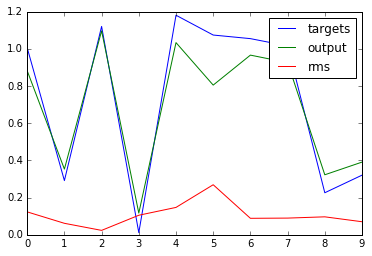

In [5]:
sim = nengo_deeplearning.Simulator(net)

sim.run_steps(1000)

# root mean squared error
print(np.sqrt(np.mean(targets.squeeze() - sim.data[p].squeeze()) ** 2))

plt.figure()
plt.plot(targets.squeeze()[:10])
plt.plot(sim.data[p].squeeze()[:10])
plt.plot(np.sqrt((targets.squeeze()-sim.data[p].squeeze())**2)[:10])
plt.legend(["targets", "output", "rms"]);

To train the network we call the `train` function on the constructed model.  The first parameter is a dict that maps `nengo.Nodes` to the input arrays we defined above (so the backend knows where to insert those inputs in the network).  The second parameter does the same for the targets.  `n_epochs` defines how many times the training process will iterate through the training data, and `minibatch_size` defines the size of the minibatches used within an epoch (once through the dataset).   `optimizer` specifies one of the optimization methods defined in `lasagne.updates` (or this could be any Theano optimizer that implements the same interface).  The `optimizer_kwargs` will be passed to the optimizer function (in this case this is setting the learning rate).

In [6]:
sim.train(dict([(input_nodes[i], inputs[..., [i]]) for i in range(3)]), 
          {output_node: targets}, 
          n_epochs=100, minibatch_size=100, 
          optimizer=lasagne.updates.adagrad, optimizer_kwargs={"learning_rate": 1e-2})

training network
Simulation finished in 0:00:02.                                                                                         
training complete


Now we can run the trained network:

0.00209371955134


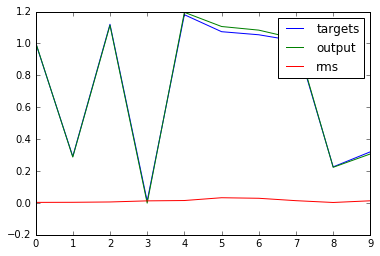

In [7]:
sim.run_steps(1000)

# root mean squared error
print(np.sqrt(np.mean(targets.squeeze() - sim.data[p].squeeze()) ** 2))

plt.figure()
plt.plot(targets.squeeze()[:10])
plt.plot(sim.data[p].squeeze()[:10])
plt.plot(np.sqrt((targets.squeeze()-sim.data[p].squeeze())**2)[:10])
plt.legend(["targets", "output", "rms"]);

You'll notice that we get a pretty small error after training. For comparison, we can run the same network with the reference simulator:

0.0123893219831


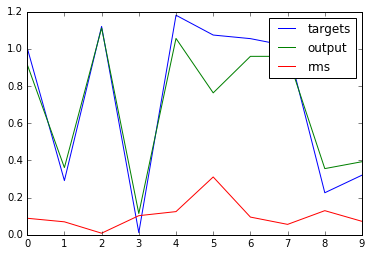

In [8]:
sim = nengo.Simulator(net)
sim.run_steps(1000)

# root mean squared error
print(np.sqrt(np.mean(targets.squeeze() - sim.data[p].squeeze()) ** 2))

plt.figure()
plt.plot(targets.squeeze()[:10])
plt.plot(sim.data[p].squeeze()[:10])
plt.plot(np.sqrt((targets.squeeze()-sim.data[p].squeeze())**2)[:10])
plt.legend(["targets", "output", "rms"]);

## Recurrent networks

Recurrent networks work in exactly the same way. One new feature being demonstrated here is the option to pass a distribution for the transform parameter.  This will cause the initial weights to be sampled from that distribution.  Any of the distributions in `nengo.dists` can be used, or any of the distributions in `lasagne.init` (access them via `nengo_deeplearning.init` to wrap them in a Nengo distribution).

Here we're implementing a 1D integrator:

checking network
building network


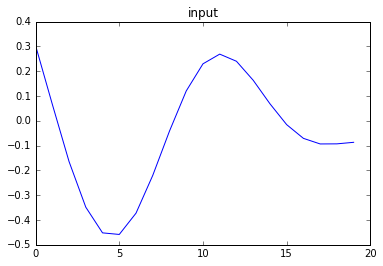

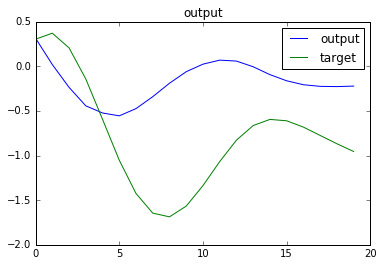

In [9]:
batch_size = 1000
sig_len = 20
dt = 1

# inputs/targets for training
white_sig_train = nengo.processes.WhiteSignal(
    period=dt*sig_len*batch_size, high=0.1, default_dt=dt, seed=0)
train_inputs = white_sig_train.run_steps(sig_len*batch_size)
train_inputs = train_inputs.reshape((batch_size, sig_len, 1)).astype(np.float32)

train_targets = np.cumsum(train_inputs, axis=1) * dt

# separate test data
white_sig_test = nengo.processes.WhiteSignal(
    period=dt*sig_len*batch_size, high=0.1, default_dt=dt, seed=1)

with nengo.Network() as net, nengo_deeplearning.default_config():
    input_node = nengo.Node(output=white_sig_test)
    ens = nengo.Ensemble(50, 1)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    # initialize weights from distribution
    nengo.Connection(ens.neurons, ens.neurons,
                     transform=nengo_deeplearning.init.GlorotUniform())
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_deeplearning.Simulator(net, dt=dt)
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=1)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[input_p][0])
plt.title('input')

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth.squeeze(), label="target")
plt.title('output')
plt.legend();

training network
Simulation finished in 0:00:05.                                                                                         
training complete


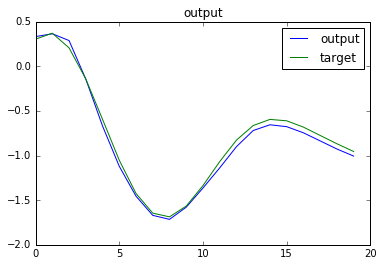

In [10]:
sim.train({input_node: train_inputs}, {output_node: train_targets},
          n_epochs=100, minibatch_size=100,
          optimizer_kwargs={"learning_rate": 1e-2})

sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=1)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth.squeeze(), label="target")
plt.title('output')
plt.legend();

When we run the network as above, `nengo_deeplearning` just runs the input node functions to generate input.  However, the inputs can also be specified directly by passing a `dict` mapping nodes to input arrays (the same format used when specifying the training inputs).  This can be useful to run a batch of inputs simultaneously:

In [11]:
test_inputs = white_sig_test.run_steps(sig_len*batch_size)
test_inputs = test_inputs.reshape((batch_size, sig_len, 1)).astype(np.float32)

test_targets = np.cumsum(test_inputs, axis=1)*dt

sim.run_steps(sig_len, {input_node: test_inputs})

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((test_targets - sim.data[output_p])**2)))

(1000, 20, 1)
0.074762


As above, we can use the NEF to initialize the weights on the recurrent connection.


checking network
building network
1.89656


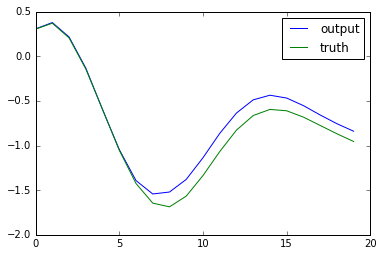

In [12]:
with nengo.Network() as net, nengo_deeplearning.default_config():
    input_node = nengo.Node(output=white_sig_test)
    ens = nengo.Ensemble(50, 1, radius=1.5)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    nengo.Connection(ens, ens)
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_deeplearning.Simulator(net, dt=dt)
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=1)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth[0], label="truth")
plt.legend()

sim.run_steps(sig_len, {input_node: test_inputs})

print(np.sqrt(np.mean((test_targets - sim.data[output_p])**2)))

training network
Simulation finished in 0:00:07.                                                                                         
training complete
(1000, 20, 1)
0.0213317


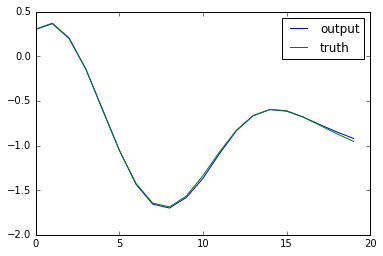

In [13]:
sim.train({input_node: train_inputs}, {output_node: train_targets},
          n_epochs=100, minibatch_size=100,
          optimizer_kwargs={"learning_rate": 1e-2})

sim.run_steps(sig_len)

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), test_targets[0], label="truth")
plt.legend()

sim.run_steps(sig_len, {input_node: test_inputs})

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((test_targets - sim.data[output_p])**2)))

# Inserting Lasagne code directly

Another thing we might want to do is write some code directly in Lasagne, and then insert that into a `nengo`/`nengo_deeplearning` model.  To do that, we can use `nengo_deeplearning.LasagneNode`.  To start, just create the desired Lasagne network (in this case we'll do a 2D convnet MNIST example):

In [14]:
# load the inputs/targets (download the dataset at
# http://deeplearning.net/data/mnist/mnist.pkl.gz)
with open("mnist.pkl", "rb") as f:
    train, _, test = pickle.load(f, encoding="bytes")
targets = np.zeros((train[1].shape[0], 1, 10), dtype=np.float32)
targets[np.arange(train[1].shape[0]), :, train[1]] = 1.0

# input layer
l = lasagne.layers.InputLayer(shape=(None,))

# reshape it into the (batch_size, n_channels, 28, 28) image shape
l = lasagne.layers.ReshapeLayer(l, shape=(-1, 1, 28, 28))

# 2 convolution/pooling layers
for _ in range(2):
    l = lasagne.layers.Conv2DLayer(l, num_filters=32, filter_size=(5, 5),
                                   nonlinearity=nl.rectify,
                                   W=lasagne.init.HeNormal(gain="relu"))
    l = lasagne.layers.MaxPool2DLayer(l, pool_size=(2, 2))

# dense layer
l = lasagne.layers.DenseLayer(l, num_units=256, nonlinearity=nl.rectify,
                              W=lasagne.init.HeNormal(gain='relu'))

# dropout
l = lasagne.layers.DropoutLayer(l, p=0.5)

# output layer
l = lasagne.layers.DenseLayer(l, num_units=10, nonlinearity=nl.softmax)

Note that the variable `l` refers to only the most recently constructed layer. However, each layer contains a reference to the previously constructed layer as well, so the entire network can be accessed through `l`.  Next we create a `LasagneNode`, and pass the output layer as the `output` parameter:

In [ ]:
with nengo.Network() as net, nengo_deeplearning.default_config():
    # 'insert_weights' is an optional config setting we can use
    # to control whether a connection weight matrix is inserted
    # for each connection, or whether we just directly connect
    # the output of the pre to the post. in this case we already
    # created all the weight matrices we want in the above
    # Lasagne network.
    net.config[nengo.Connection].set_param(
        "insert_weights", nengo.params.BoolParam("insert_weights", False))

    # input node will just present one input image per timestep
    input_node = nengo.Node(output=PresentInput(test[0], 0.001))
    
    # insert the convolutional network we defined above
    conv_layers = nengo_deeplearning.layers.LasagneNode(output=l, size_in=784)
    
    # output node
    output_node = nengo.Node(size_in=10)

    nengo.Connection(input_node, conv_layers)
    nengo.Connection(conv_layers, output_node)

    input_p = nengo.Probe(input_node)
    p = nengo.Probe(output_node)

When we build the network, `nengo_deeplearning` will compile the contents of the `LasagneNode` directly into the network graph.  This means that we can train the parameters inside the `LasagneNode` in the same way as we did previously:

In [ ]:
sim = nengo_deeplearning.Simulator(net)

# we'll use a different optimizer function here, nesterov_momentum.
# we'll also use a different objective, categorical_crossentropy,
# as opposed to the default squared error we were using previously.
sim.train({input_node: train[0][:, None]}, {output_node: targets},
          n_epochs=10, minibatch_size=500,
          optimizer=lasagne.updates.nesterov_momentum,
          optimizer_kwargs={"learning_rate": 0.01, "momentum": 0.9},
          objective=lasagne.objectives.categorical_crossentropy)

checking network
building network
training network
[################################################# 50%                                                  ] ETA: 0:00:06

If we run the trained network, we can see it getting ~98% accuracy on the test set.  Note that we're only training for 10 epochs, which is relatively small.  If you have more patience you can change the `n_epochs` parameter above to 100/200, which should get >99% accuracy.

In [ ]:
sim.run_steps(test[0].shape[0])

output = sim.data[p].squeeze()

print(np.mean(np.argmax(output, axis=1) == test[1]))

But that's not all!  One of the nice things about `LasagneNode` is that it's just a thin wrapper around a regular `nengo.Node`.  That means that we can take the same MNIST network (which contains our trained `LasagneNode`), and build it using reference `nengo` instead:

In [ ]:
sim = nengo.Simulator(net)
sim.run_steps(test[0].shape[0])

output = sim.data[p]

print(np.mean(np.argmax(output, axis=1) == test[1]))

And there we go, the same Lasagne network is now running within regular Nengo.